In [11]:
import sys
from itertools import combinations
from os.path import expanduser

import numpy as np
import pandas as pd

import safe
# Import functions from file: s_cerevisiae/python/scripts/webapp/export_corr_tsv_for_webapp.py
from _modules import (
    get_valid_genes_from_loci,
    filter_corr_for_webapp_export,
    load_and_filter_corr_tsv,
    get_fm_fm_corr,
    get_corr_score,
    get_fm_term_from_id,
    is_overlapping_genes,
    utils,
)


# Load mapping of FM ID terms to genes as found in total-JSON
fm_id_to_term_and_genes = utils.pipeline.fm.map_id_to_term_and_genes(utils.get_path_from_config("total-json"))

%matplotlib inline

# Annotating a functional module networkm

In [7]:
# Instantiate SAFE
sf = safe.SAFE()

### Load and display the network

In [8]:
# Option 3: Load Cytoscape session file
sf.load_network(
    network_file='../safe-data/networks/metabolic-enrichment-network-apr-1m.cys',
    node_key_attribute='label' # i.e., node labels
)

Loading network from ../safe-data/networks/metabolic-enrichment-network-apr-1m.cys
Loading the cys file ../safe-data/networks/metabolic-enrichment-network-apr-1m.cys...
Loading the view: CytoscapeSession-2023_09_20-14_18/views/124-28406-cytoscape_metabolic_fm.json.xgmml
Loading the first network: CytoscapeSession-2023_09_20-14_18/networks/83-cytoscape_metabolic_fm.json.xgmml
Calculating edge lengths...


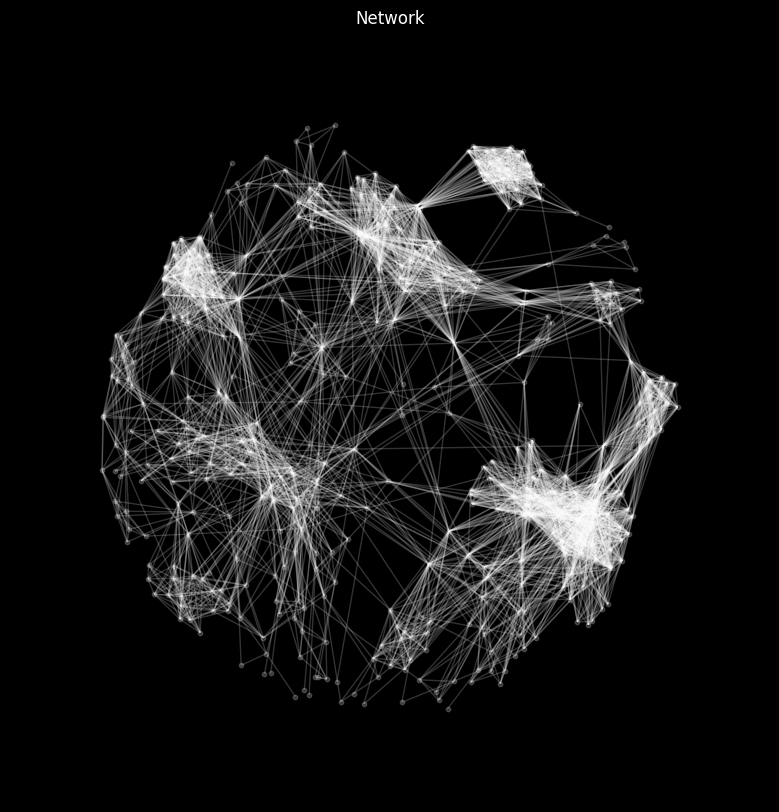

In [9]:
# View network as exported by Cytoscape
sf.plot_network()

In [10]:
# Create mappings - will be used later for annotation
node_id_to_fm_id = dict(zip(sf.nodes['id'], sf.nodes['key']))
fm_id_to_node_id = dict(zip(sf.nodes['key'], sf.nodes['id']))
fm_id_to_genes = dict(zip(sf.nodes['key'], map(lambda x: fm_id_to_term_and_genes[x]['genes'], sf.nodes['key'])))


In [36]:
# BUILD SIMILARITY MATRIX (I.E., A BINARY MATRIX) THAT SHOWS A RELATIONSHIP BETWEEN FM X FM (SQUARE MATRIX)
# IN THIS EXAMPLE, WORK WITH OVERLAPPING GENE JACCARD INDICES

def compute_jaccard_index(df, column1, column2, result_column):
    """Computes Jaccard Index between `column1` and `column2` in `df` and assigns the value to `result_column`."""
    df[result_column] = df.apply(
        lambda row: len(set(get_genes_for_fm_id(row[column1])) & set(get_genes_for_fm_id(row[column2]))) / len(set(get_genes_for_fm_id(row[column1])) | set(get_genes_for_fm_id(row[column2]))), axis=1)
    return df

def get_genes_for_fm_id(fm_id):
    """Gets functional module genes from functional module ID."""
    return fm_id_to_term_and_genes[fm_id]['genes']


# Create a DataFrame to store combinations of all possible node x node in the network
query_id_combinations = list(combinations(sf.nodes['key'], 2))
# For compatibility's sake, assign first column as 'query_id' and second column as 'array_id'
relationship_data = pd.DataFrame(query_id_combinations, columns=['query_id', 'array_id'])
# Remove rows where values in the two columns are equal
relationship_data = relationship_data[relationship_data['query_id'] != relationship_data['array_id']]

# Add Jaccard Index to determine degrees of gene overlap per row
min_jaccard_idx = 0.5
# Add column for Jaccard Index measuring degrees of overlapping genes - for 
relationship_data = compute_jaccard_index(relationship_data, 'query_id', 'array_id', 'jaccard index')
# Now, remove rows where 'jaccard index' is greater than `min_jaccard_idx`
relationship_data = relationship_data[relationship_data['jaccard index'] > min_jaccard_idx].reset_index(drop=True)
relationship_data.shape


(590, 3)

In [12]:
# IN THIS EXAMPLE, WORK WITH FM X FM GENETIC INTERACTION PROFILE CORRELATION
# FM correlation-related configs

FM_ID_TO_TERM_AND_GENES = utils.pipeline.fm.map_id_to_term_and_genes(
    utils.get_path_from_config("total-json")
)
VALID_LOCI_TXT_PATH = utils.get_path_from_config("sgd-data-txt") / "loci" / "valid_loci.txt"
UPLOAD_CORR_TSV_PATH = (
    utils.get_path_from_config("total-export-gi")
    / "concat"
    / "2023Apr_1m"
    / "neg_pos_gi_concat_corr.tsv"
)
EXPORT_FM_CORR_TSV_CONFIG = {
    # Configure thresholds for loading
    "load-min-corr": 0.0,
    "load-max-corr": 0.999999,
    "load-max-pval": 10e-2,
    # Configure thresholds for exporting
    "export-min-corr": 0.0,
    "export-max-corr": 0.999999,
    "export-max-pval": 10e-02,
}

# Load FM correlation data for plotting
from functools import partial

locus_id_to_genes = utils.sgd.get_locus_ids_to_genes_map()
valid_genes = get_valid_genes_from_loci(locus_id_to_genes, VALID_LOCI_TXT_PATH)

fm_fm_corr = load_and_filter_corr_tsv(
    partial(get_fm_fm_corr, genes=valid_genes), UPLOAD_CORR_TSV_PATH, EXPORT_FM_CORR_TSV_CONFIG
)
fm_fm_corr_export = filter_corr_for_webapp_export(
    fm_fm_corr, EXPORT_FM_CORR_TSV_CONFIG, FM_ID_TO_TERM_AND_GENES
)


Loading correlation TSV file for filtering...
Filtering correlation DataFrame for export...


In [37]:
# Assign cutoffs to build a sparse relationship binary matrix
relationship_data = fm_fm_corr_export[(fm_fm_corr_export['corr'] > 0.7) & (fm_fm_corr_export['query_id'].isin(sf.nodes['key'])) & (fm_fm_corr_export['array_id'].isin(sf.nodes['key']))]
relationship_data = relationship_data[['query_id', 'array_id', 'corr']]
relationship_data = relationship_data.rename(columns={'corr': 'jaccard index'})
relationship_data.shape


(4176, 3)

In [39]:
# Build binary matrix

# Map functional module ID to node ID in relationship matrix
# Node IDs are integers, starting with 0 --> (num rows | num columns)
relationship_data = relationship_data.replace({"query_id": fm_id_to_node_id, 'array_id': fm_id_to_node_id})
# Instantiate binary matrix equal in size as the number of nodes in the graph (build a square matrix)
binary_matrix = np.zeros((len(sf.nodes), len(sf.nodes)))

# Iterate over the DataFrame and update the binary matrix
for index, row in relationship_data.iterrows():
    query_id = row['query_id']
    array_id = row['array_id']
    value = row['jaccard index']
    # We are already working with a null matrix - only change value if a relationship between row and column is found
    if value != 0:
        binary_matrix[int(query_id), int(array_id) - 1] = 1  # Subtract 1 to adjust for 0-based indexing


In [40]:
# This is where it gets a bit weird due to the way SAFE is written... change instance attributes
# Mapping of Node IDs to functional module terms
sf.attributes = pd.DataFrame([range(len(sf.nodes['key'])), map(lambda x: fm_id_to_term_and_genes[x]['term'], sf.nodes['key'])]).T.rename(columns={0: 'id', 1: 'name'})
# Assign binary relationship matrix to node-to-attribute attribute
sf.node2attribute = binary_matrix


### Load the attributes

Here we are using a Gene Ontology (GO) biological process dataset as a set of attributes. These data, just like any other attribute file, needs to be provided in matrix format (genes as rows; GO terms as columns; 1/0 values for each gene annotated/not annotated to a GO term).

This GO matrix can be generated from the GO tree (go-basic.obo file available at http://geneontology.org/docs/download-ontology/) and the species-specific gene-to-GO term annotation file (a gaf file available at http://current.geneontology.org/products/pages/downloads.html) using a script provided in `safepy/utils/make_go.py`.

For more detailed format specifications, check the example attribute file. The main format requirements are:
* the first column contains the node labels (in this case, yeast ORFs)
* each column is an attribute
* the row labels in the attribute file should be matching the node keys in the network.



In [41]:
# sf.load_attributes(attribute_file='../safe-data/attributes/go_bp_140819.txt.gz')


### Define the local neighborhoods and compute their enrichment for each attribute

In [42]:
# Explicitly define the node_distance metric and the neighborhood radius
sf.define_neighborhoods(node_distance_metric='shortpath_weighted_layout', neighborhood_radius=0.05)

Node distance metric: shortpath_weighted_layout
Neighborhood definition: 0.05 x diameter
Number of nodes per neighborhood (mean +/- std): 6.07 +/- 4.38


In [43]:
# sf.compute_pvalues_by_randomization(num_permutations=100, processes=7)
sf.enrichment_type = "permutation"
sf.num_permutations=1000
sf.compute_pvalues(processes=7)

Current settings (possibly overwriting global ones):
	processes=7
Using randomization to calculate enrichment...


100%|██████████| 143/143 [00:06<00:00, 23.13it/s]


### Plot the enrichment landscapes of a sample of attributes

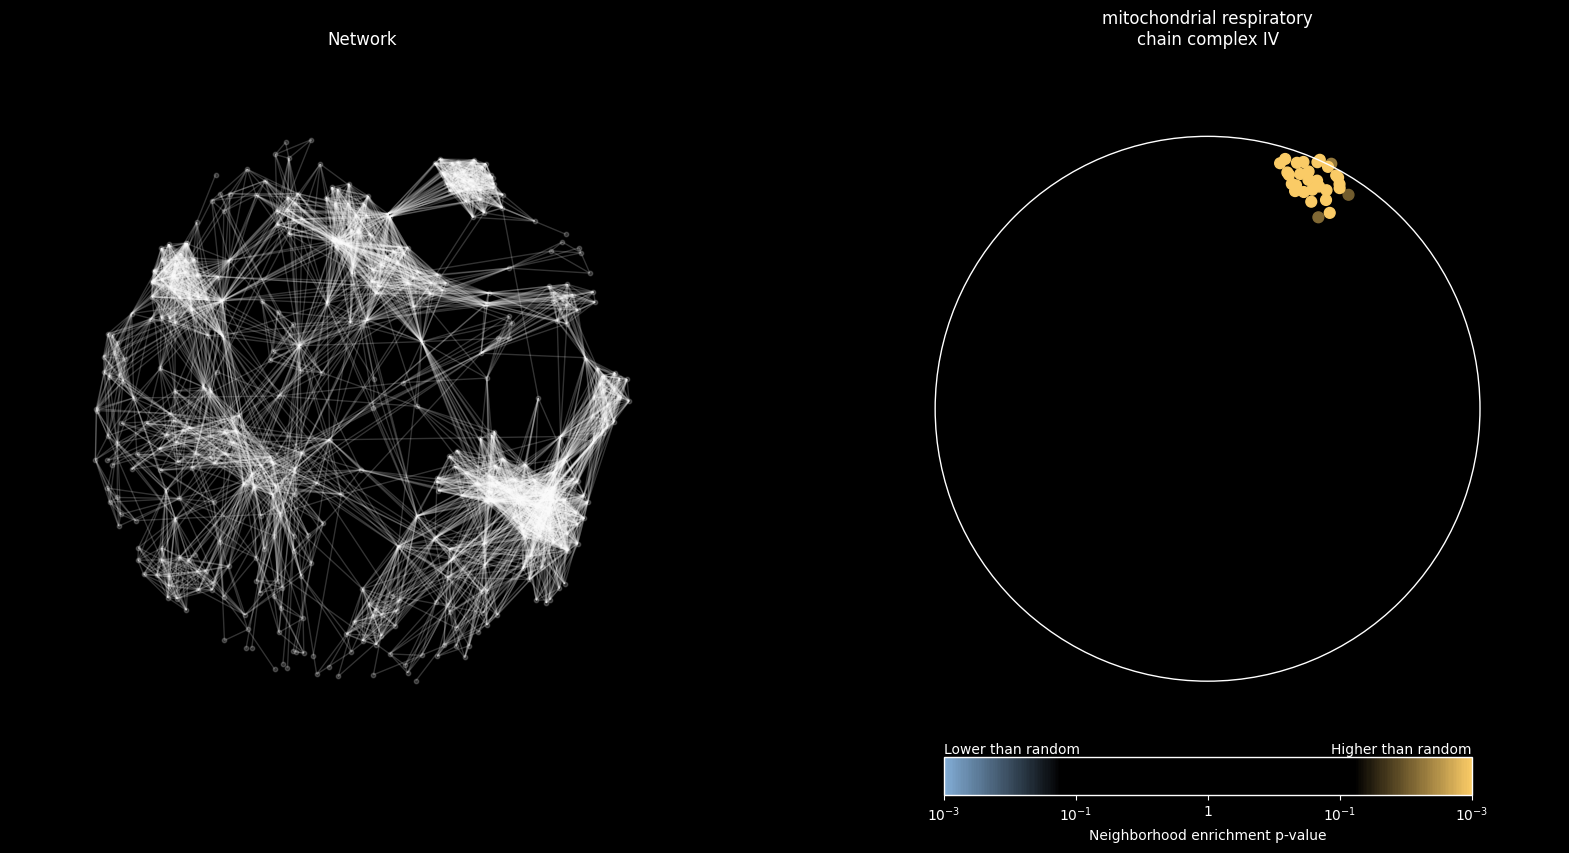

In [47]:
# Just the enrichment itself with min and max boundaries on the colormap
sf.plot_sample_attributes()

### Combine the enrichment landscapes into a single composite map

In [50]:
sf.define_top_attributes()

Criteria for top attributes:
- minimum number of enriched neighborhoods: 10
- region-specific distribution of enriched neighborhoods as defined by: connectivity
Number of top attributes: 274


In [51]:
sf.define_domains(attribute_distance_threshold=0.85)

Number of domains: 15 (containing 2-31 attributes)


In [52]:
sf.trim_domains()

Removed 0 domains because they were the top choice for less than 10 neighborhoods.


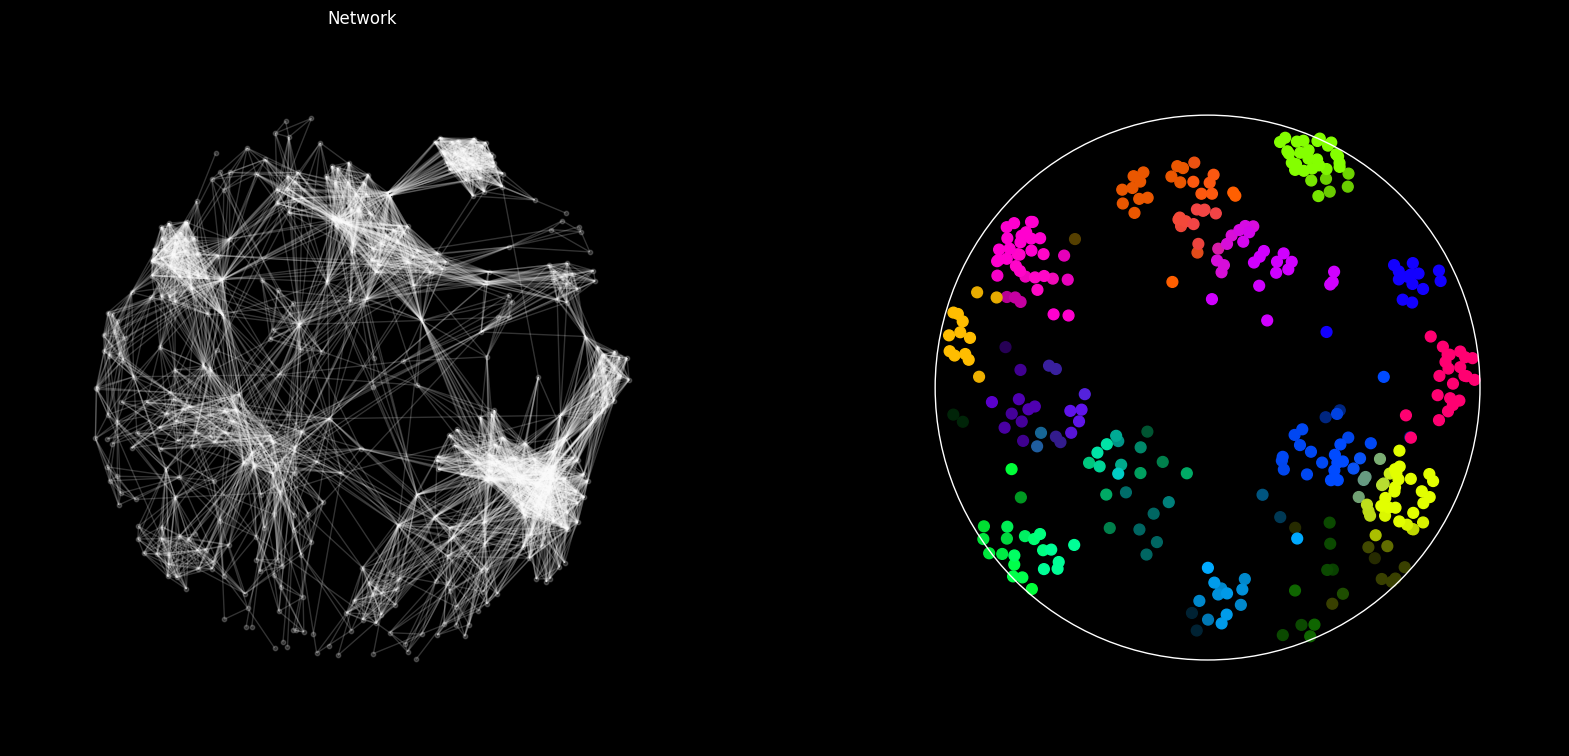

In [54]:
sf.plot_composite_network(show_each_domain=False, show_domain_ids=False)#, save_fig="./png/metabolic-network-safe.png")

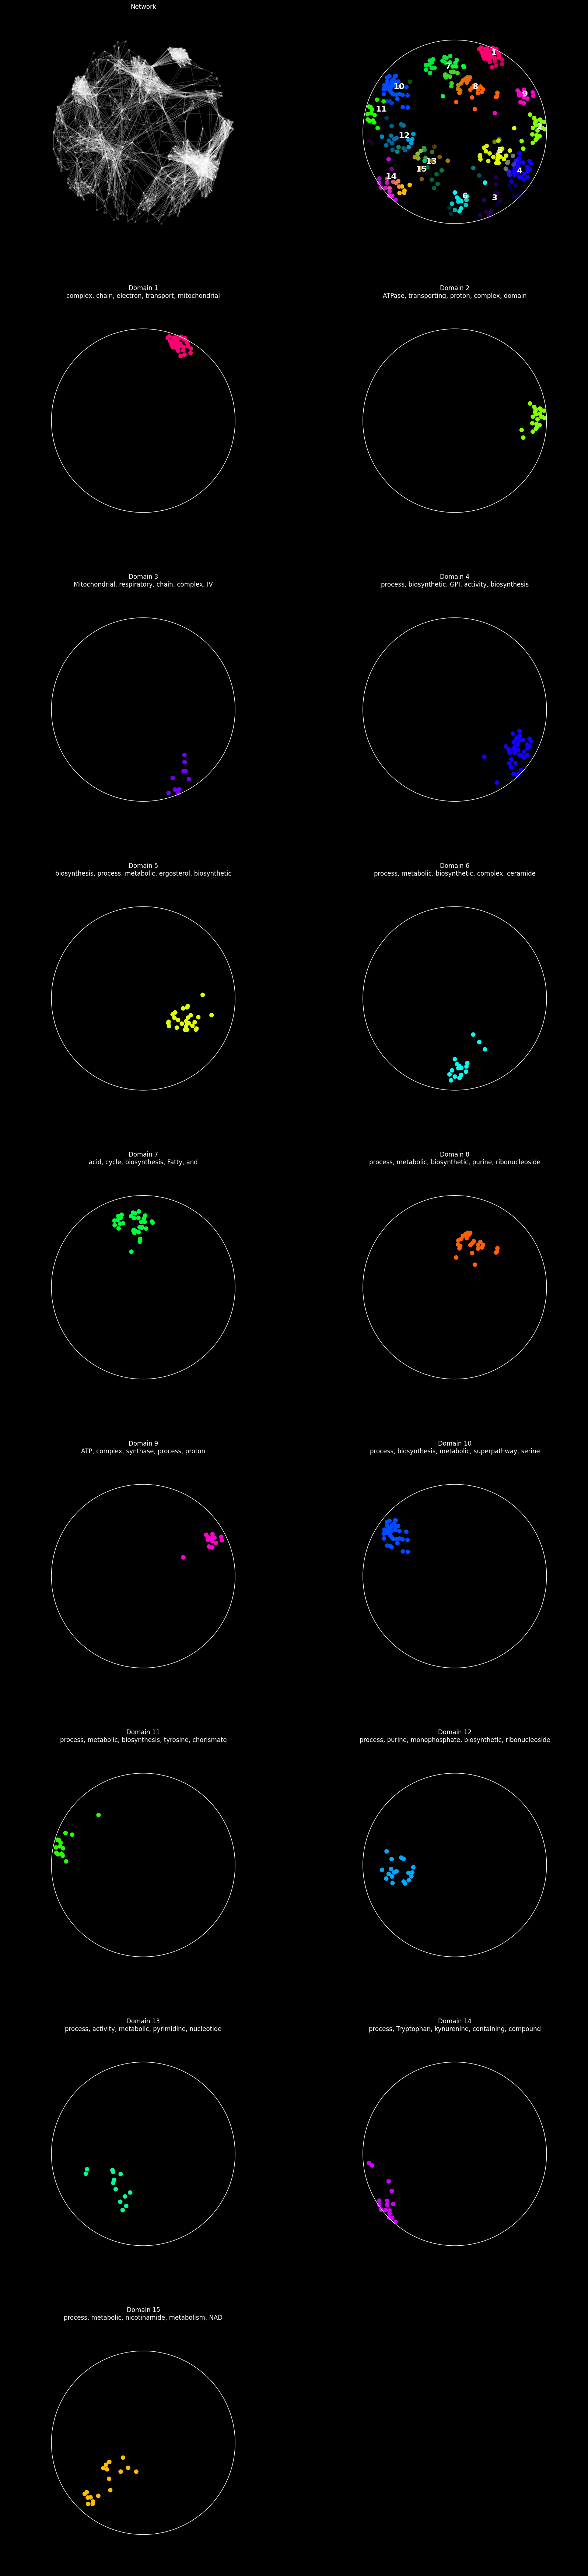

In [55]:
sf.plot_composite_network(show_each_domain=True, labels=[])

In [373]:
sf.print_output_files(output_dir='./')

./domain_properties_annotation.txt
./attribute_properties_annotation.txt
./node_properties_annotation.txt


In [24]:
sf.save(output_dir='./')